# Downloading, pre-processing and running cNMF on Zepp et. al 2021 data
1. Obtaining the AnnData object and complementary metadata
2. filtering genes, and showing key statistics
3. Subsetting and splitting the dataset by developmental stage, and selecting joint highly variable genes (HVG)
4. Running consensus NMF (cNMF) per stage
5. Selecting parameters for the cNMF
6. Running the comparator for adjacent steps



In [1]:
%%time
%load_ext autoreload
%autoreload 2

#debug:
from importlib import reload

import sys
import os
import time

import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.metrics import silhouette_samples
import scanpy as sc
import matplotlib.pyplot as plt

from gepdynamics import _utils
from gepdynamics import _constants
from gepdynamics import cnmf
from gepdynamics import comparator

_utils.cd_proj_home()
print(os.getcwd())



/cs/labs/mornitzan/yotamcon/gep-dynamics
CPU times: user 4.35 s, sys: 1.95 s, total: 6.31 s
Wall time: 1min 44s


## 1. Obtaining the AnnData object and complementary metadata
The adata contains log1p(CP10K) data, we un-transform the data to have the original counts as `X`

In [17]:
results_dir = _utils.set_dir('results')
results_dir = _utils.set_dir(results_dir.joinpath('zepp'))
data_dir = _utils.set_dir('data')
GSE_dir = _utils.set_dir(data_dir.joinpath('GSE149563'))

In [4]:
%%script --no-raise-error false # remove this to run the downloading

# Adata downloaded from https://data-browser.lungmap.net/explore/projects/00f056f2-73ff-43ac-97ff-69ca10e38c89/get-curl-command
# by running this for the adata: 
!(cd {GSE_dir.as_posix()} && curl --location --fail 'https://service.azul.data.humancellatlas.org/manifest/files?catalog=lm3&format=curl&filters=%7B%22fileFormat%22%3A+%7B%22is%22%3A+%5B%22h5ad%22%5D%7D%2C+%22projectId%22%3A+%7B%22is%22%3A+%5B%2200f056f2-73ff-43ac-97ff-69ca10e38c89%22%5D%7D%2C+%22genusSpecies%22%3A+%7B%22is%22%3A+%5B%22Mus+musculus%22%5D%7D%7D&objectKey=manifests%2Fe42d976a-5137-5422-be32-39008e1d53d7.1ad7b2a4-0d0f-55d3-9d0c-6c37e8d46dc8.curlrc' | curl --config - )
# and then running this for the metadata: 
!(cd {GSE_dir.as_posix()} && curl --location --fail 'https://service.azul.data.humancellatlas.org/manifest/files?catalog=lm3&format=curl&filters=%7B%22fileFormat%22%3A+%7B%22is%22%3A+%5B%22csv%22%5D%7D%2C+%22projectId%22%3A+%7B%22is%22%3A+%5B%2200f056f2-73ff-43ac-97ff-69ca10e38c89%22%5D%7D%2C+%22genusSpecies%22%3A+%7B%22is%22%3A+%5B%22Mus+musculus%22%5D%7D%7D&objectKey=manifests%2Fed538a08-689b-530d-a661-e1756132b883.1ad7b2a4-0d0f-55d3-9d0c-6c37e8d46dc8.curlrc' | curl --config -)

download_dir = GSE_dir.joinpath('a078a6cb-a72a-305c-80df-cf35aedd01ff')
! mv {download_dir.as_posix()}/* {GSE_dir.as_posix()}
! rmdir {download_dir.as_posix()}

In [12]:
%%time

%time adata = sc.read(GSE_dir.joinpath('JZ_Mouse_TimeSeries.h5ad'))
metadata = pd.read_csv(GSE_dir.joinpath('AllTimePoints_metadata.csv'), index_col=0)

adata.obs['celltype'] = metadata.var_celltype
adata.obs['compartment'] = metadata.var_compartment

untransformed = sparse.csr_matrix(adata.obs.n_molecules.values[:, None].astype(np.float32) / 10_000).multiply(adata.X.expm1())
adata.X = sparse.csc_matrix(untransformed).rint()

del untransformed

adata

CPU times: user 4.62 s, sys: 358 ms, total: 4.97 s
Wall time: 11.8 s
CPU times: user 8.37 s, sys: 836 ms, total: 9.21 s
Wall time: 16 s


AnnData object with n_obs × n_vars = 67794 × 18129
    obs: 'development_stage', 'n_molecules', 'n_genes', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'var_time', 'cell_type', 'CellID', 'cell_names', 'celltype', 'compartment'
    var: 'name'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [13]:
adata.obs.development_stage = adata.obs.development_stage.cat.rename_categories(
    {'Adult': 'P42', 'E12.5': 'E12', 'E15.5': 'E15', 'E17.5': 'E17'}).cat.reorder_categories(
    ['E12', 'E15', 'E17', 'P3', 'P7', 'P15', 'P42'])

/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


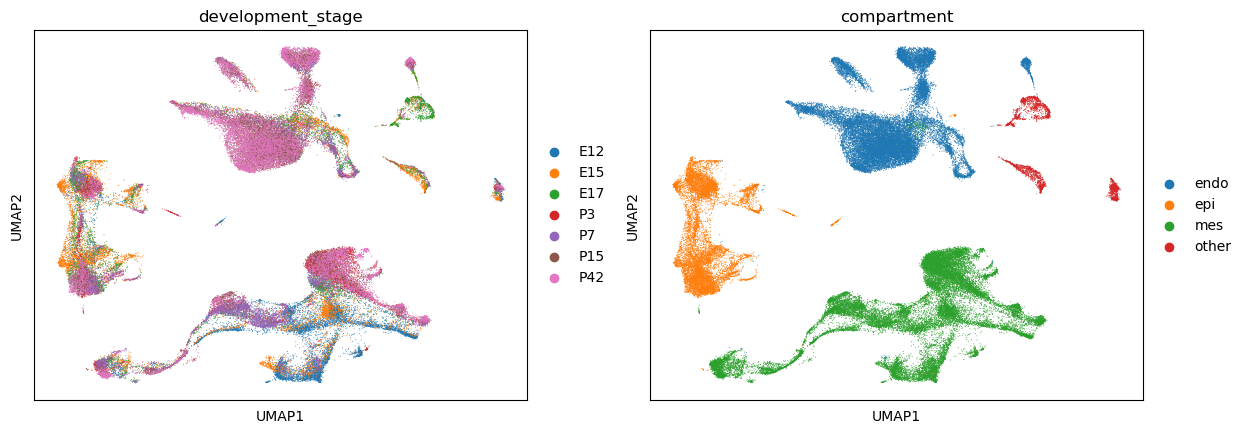

/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


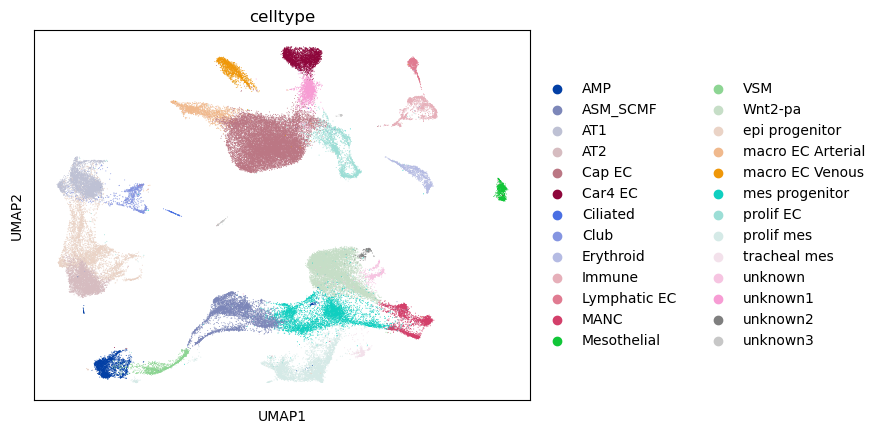

In [14]:
sc.pl.umap(adata, color=['development_stage', 'compartment'])
sc.pl.umap(adata, color=['celltype'])

adata.uns['development_stage_colors_dict'] = dict(zip(adata.obs['development_stage'].cat.categories, adata.uns['development_stage_colors']))
adata.uns['compartment_colors_dict'] = dict(zip(adata.obs['compartment'].cat.categories, adata.uns['compartment_colors']))
adata.uns['celltype_colors_dict'] = dict(zip(adata.obs['celltype'].cat.categories, adata.uns['celltype_colors']))

In [15]:
pd.crosstab(adata.obs.development_stage, adata.obs.compartment)

compartment,endo,epi,mes,other
development_stage,,,,
E12,133,679,7752,403
E15,1095,3676,2516,1017
E17,1681,2573,2012,937
P3,2991,2196,5063,141
P7,3992,1632,4433,140
P15,7345,739,2327,108
P42,7646,1041,3404,122


In [16]:
pd.crosstab(adata.obs.celltype, adata.obs.development_stage)

development_stage,E12,E15,E17,P3,P7,P15,P42
celltype,,,,,,,
AMP,178,224,317,327,356,189,376
ASM_SCMF,732,227,417,678,1936,378,263
AT1,125,711,779,865,344,248,355
AT2,54,243,739,815,811,432,517
Cap EC,55,557,783,1517,2073,5239,4875
Car4 EC,0,0,30,346,430,908,1078
Ciliated,0,0,5,61,5,2,4
Club,112,418,157,94,72,26,54
Erythroid,53,601,114,18,70,65,7


In [17]:
pd.crosstab(adata.obs.celltype, adata.obs.compartment)

compartment,endo,epi,mes,other
celltype,,,,
AMP,0,0,1967,0
ASM_SCMF,0,0,4631,0
AT1,0,3427,0,0
AT2,0,3611,0,0
Cap EC,15099,0,0,0
Car4 EC,2792,0,0,0
Ciliated,0,77,0,0
Club,0,933,0,0
Erythroid,0,0,0,928


## 2. filtering genes, selecting joint highly variable genes (HVGs) and showing key statistics


In [18]:
%%time
print(f'before filtering shape was {adata.X.shape}')

# filtering genes with very low abundance
sc.pp.filter_genes(adata, min_cells=np.round(adata.shape[0] / 1000))

# getting general statistics for counts abundance
sc.pp.filter_genes(adata, min_counts=0)
sc.pp.filter_cells(adata, min_counts=0)
sc.pp.filter_cells(adata, min_genes=0)

sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=_constants.NUMBER_HVG)

print(f'after filtering shape is {adata.X.shape}')

adata

before filtering shape was (67794, 18129)
after filtering shape is (67794, 16184)
CPU times: user 7.12 s, sys: 1.83 s, total: 8.95 s
Wall time: 10.8 s


AnnData object with n_obs × n_vars = 67794 × 16184
    obs: 'development_stage', 'n_molecules', 'n_genes', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'var_time', 'cell_type', 'CellID', 'cell_names', 'celltype', 'compartment', 'n_counts'
    var: 'name', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'development_stage_colors', 'compartment_colors', 'celltype_colors', 'development_stage_colors_dict', 'compartment_colors_dict', 'celltype_colors_dict', 'hvg'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

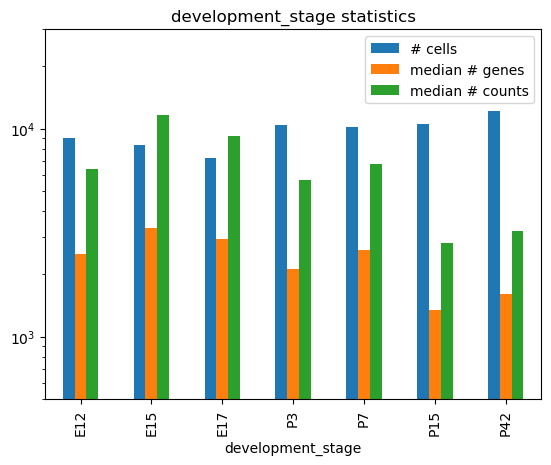

In [20]:
column_of_interest = 'development_stage'

stats_df = adata.obs.loc[:, [column_of_interest, 'n_genes', 'n_counts']].groupby(
    [column_of_interest]).median()

stats_df = pd.concat([adata.obs.groupby([column_of_interest]).count().iloc[:, 0],
                      stats_df], axis=1)
stats_df.columns = ['# cells', 'median # genes', 'median # counts']

stats_df.plot(kind='bar', title=f'{column_of_interest} statistics', log=True, ylim=((5e2, 3e4)))
plt.show()
del column_of_interest, stats_df

In [21]:
_utils.joint_hvg_across_stages(adata, obs_category_key='development_stage', n_top_genes=5000)
adata.var

,name,n_cells,n_counts,highly_variable,highly_variable_rank,means,variances,variances_norm,development_stage_max_var_norm,joint_highly_variable
Sox17,Sox17,18167,41543.0,True,954.0,0.612783,2.185803,1.911305,6.756488,True
Mrpl15,Mrpl15,22890,36466.0,False,NaN,0.537894,0.938963,0.989088,0.989088,False
Lypla1,Lypla1,18216,23039.0,False,NaN,0.339838,0.400800,0.778880,0.927863,False
Tcea1,Tcea1,29410,45005.0,False,NaN,0.663849,0.906531,0.705129,0.918159,False
Atp6v1h,Atp6v1h,13201,15381.0,False,NaN,0.226878,0.249574,0.790966,0.928798,False
...,...,...,...,...,...,...,...,...,...,...
Gm12185,Gm12185,159,160.0,False,NaN,0.002360,0.002384,0.855554,0.904272,False
Olfr56,Olfr56,227,237.0,False,NaN,0.003496,0.003808,0.879820,0.970031,False
Slc22a12,Slc22a12,68,70.0,False,NaN,0.001033,0.001090,1.022095,1.022095,False
Ido1,Ido1,80,81.0,False,NaN,0.001195,0.001223,0.964506,0.964506,False


### Saving/loading the pre-processed object

In [55]:
%%time
pre_processed_adata_file = results_dir.joinpath('full.h5ad')

if not pre_processed_adata_file.exists():
    adata.write(pre_processed_adata_file)
else:
    adata = sc.read(pre_processed_adata_file)
adata

CPU times: user 254 ms, sys: 569 ms, total: 823 ms
Wall time: 14.8 s


AnnData object with n_obs × n_vars = 67794 × 16184
    obs: 'development_stage', 'n_molecules', 'n_genes', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'var_time', 'cell_type', 'CellID', 'cell_names', 'celltype', 'compartment', 'n_counts'
    var: 'name', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'development_stage_max_var_norm', 'joint_highly_variable'
    uns: 'celltype_colors', 'celltype_colors_dict', 'compartment_colors', 'compartment_colors_dict', 'development_stage_colors', 'development_stage_colors_dict', 'hvg'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

## 3. Subsetting and splitting the dataset by stage, and selecting joint highly variable genes (HVG)


### Splitting the adata by "development_stage", retaining only epithelial cells and creating a normalized variance layer

/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


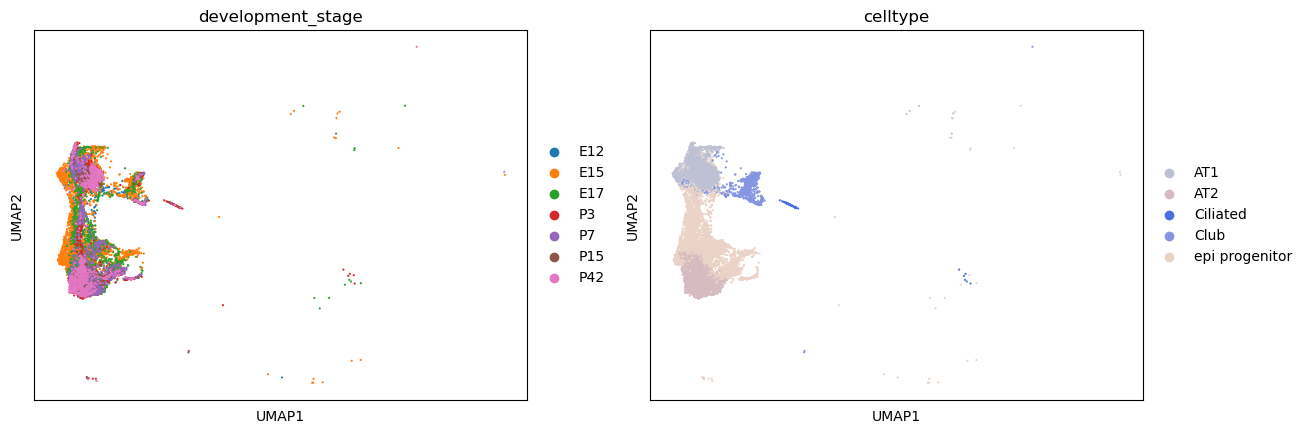

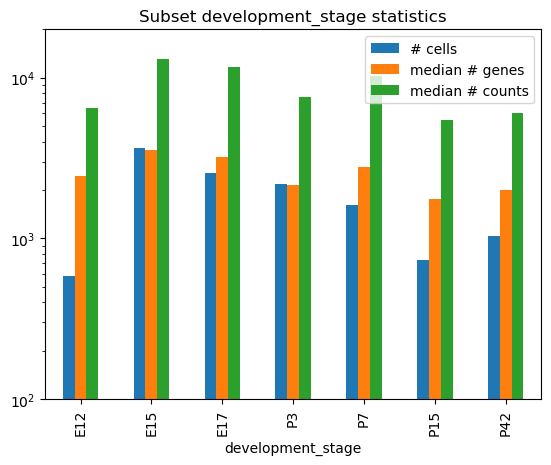

CPU times: user 1.59 s, sys: 724 ms, total: 2.31 s
Wall time: 6.89 s


AnnData object with n_obs × n_vars = 12399 × 16179
    obs: 'development_stage', 'n_molecules', 'n_genes', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'var_time', 'cell_type', 'CellID', 'cell_names', 'celltype', 'compartment', 'n_counts'
    var: 'name', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'development_stage_max_var_norm', 'joint_highly_variable'
    uns: 'celltype_colors', 'celltype_colors_dict', 'compartment_colors', 'compartment_colors_dict', 'development_stage_colors', 'development_stage_colors_dict', 'hvg'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [18]:
%%time

column_of_interest = 'development_stage'

subset_adata_file = results_dir.joinpath('subset.h5ad')

if not subset_adata_file.exists():
    subset = adata[(adata.obs.compartment == 'epi') & (adata.obs.celltype != 'unknown3')].copy()

    sc.pp.filter_genes(subset, min_cells=1)
    sc.pp.filter_genes(subset, min_counts=1)

    _utils.joint_hvg_across_stages(subset, obs_category_key=column_of_interest, n_top_genes=5000)

    subset.write(subset_adata_file)
else:
    subset = sc.read(subset_adata_file)

# umap by celltype:
sc.pl.umap(subset, color=[column_of_interest, 'celltype'])

# statistics
stats_df = subset.obs.loc[:, [column_of_interest, 'n_genes', 'n_counts']].groupby(
    [column_of_interest]).median()

stats_df = pd.concat([subset.obs.groupby([column_of_interest]).count().iloc[:, 0],
                      stats_df], axis=1)
stats_df.columns = ['# cells', 'median # genes', 'median # counts']

stats_df.plot(kind='bar', title=f'Subset {column_of_interest} statistics', log=True, ylim=((1e2, 2e4)))
plt.show()
del stats_df

subset

In [19]:
%%time

categories = subset.obs[column_of_interest].cat.categories

split_adatas_dir = _utils.set_dir(results_dir.joinpath(f'split_{column_of_interest}'))

for cat in categories:
    print(f'working on {cat}')
    if not split_adatas_dir.joinpath(f'{cat}.h5ad').exists():
        tmp = subset[subset.obs[column_of_interest] == cat].copy()

        tmp.uns['name'] = f'{cat}'   # full name
        tmp.uns['sname'] = f'{cat[:3]}'  # short name, here it is the same

        # correcting the gene counts
        sc.pp.filter_genes(tmp, min_cells=0)
        sc.pp.filter_genes(tmp, min_counts=0)

        tmp.write_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))

        del tmp

working on E12
working on E15
working on E17
working on P3
working on P7
working on P15
working on P42
CPU times: user 2.97 ms, sys: 1.16 ms, total: 4.12 ms
Wall time: 110 ms


## 4. Running consensus NMF iterations

In [20]:
cnmf_dir = _utils.set_dir(results_dir.joinpath('cnmf'))

In [113]:
%%time

ks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]#, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

for cat in categories:
    print(f'Starting on {cat}, time is {time.strftime("%H:%M:%S", time.localtime())}')
    tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))
    
    c_object = cnmf.cNMF(cnmf_dir, cat)
    
    # Variance normalized version of the data
    X = sc.pp.scale(tmp.X[:, tmp.var.joint_highly_variable].toarray().astype(np.float32), zero_center=False)
    
    c_object.prepare(X, ks, n_iter=100, new_nmf_kwargs={'tol': _constants.NMF_TOLERANCE,
                                                        'beta_loss': 'kullback-leibler'})
    
    c_object.factorize(0, 1, gpu=True)
    
    c_object.combine()
    
    del tmp, X

Starting on E12, time is 11:39:10
Combining factorizations for k=2.
Combining factorizations for k=3.
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Combining factorizations for k=13.
Combining factorizations for k=14.
Starting on E15, time is 11:43:12
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Combining factorizations for k=13.
Combining factorizations for k=14.
Starting on P3, time is 12:00:00
Combining factorizations for k=2.
Combining factorizations for k=3.
Combi

Starting on E12, time is 22:19:01
working on threshold 0.5


KeyboardInterrupt: 

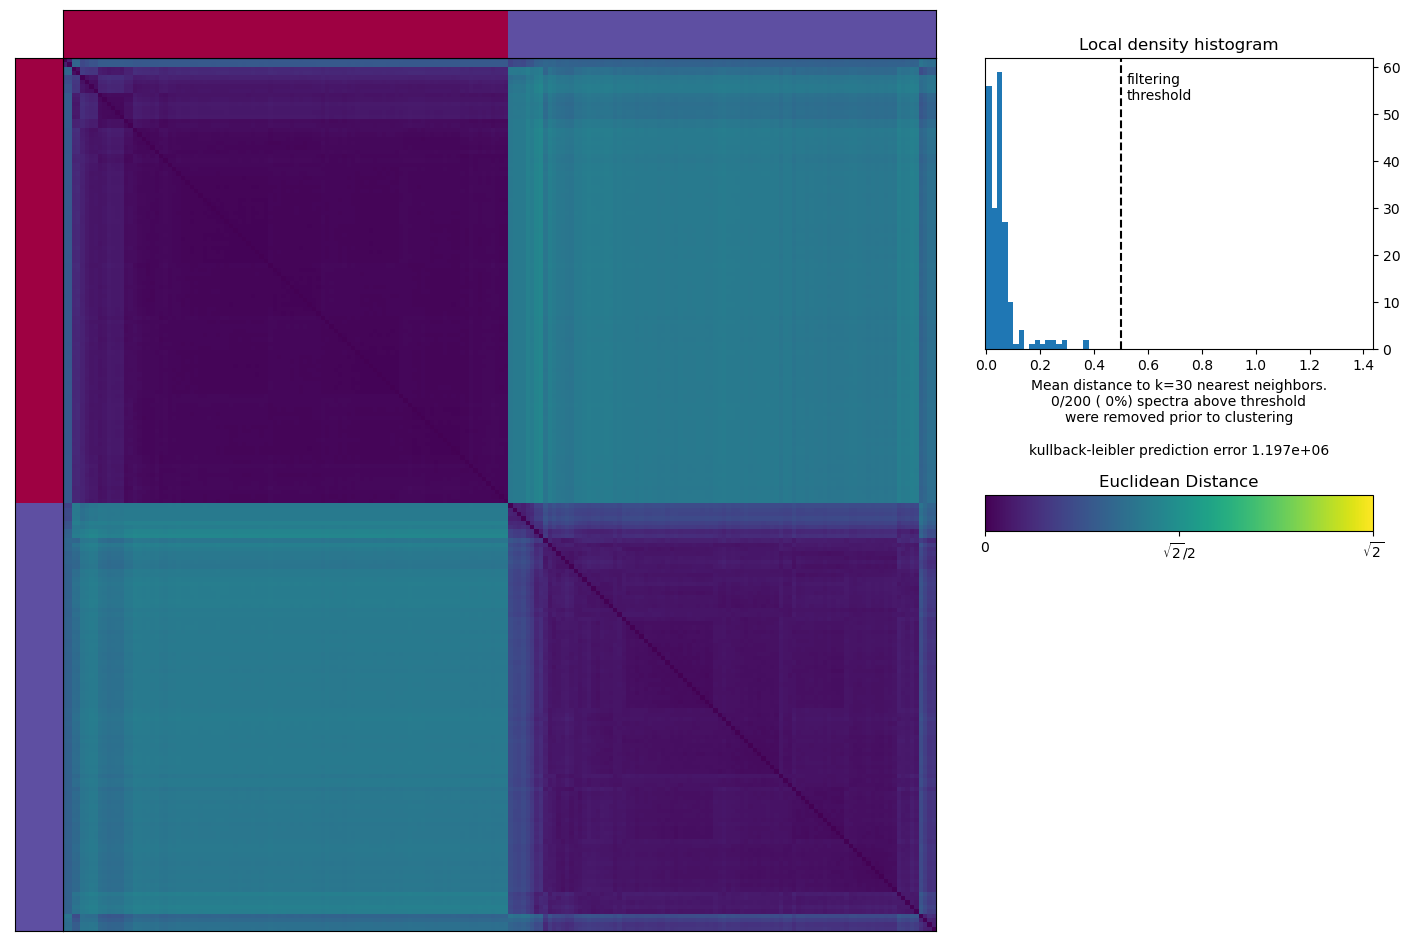

In [62]:
%%time
for cat in categories:
    print(f'Starting on {cat}, time is {time.strftime("%H:%M:%S", time.localtime())}')
    c_object = cnmf.cNMF(cnmf_dir, cat)
    for thresh in [0.5, 0.4, 0.3]:
        print(f'working on threshold {thresh}')
        c_object.k_selection_plot(density_threshold=thresh, nmf_refitting_iters=1000, 
                                  consensus_method='mean',
                                  close_fig=True, show_clustering=True, gpu=True)
        # printing the selected knee point
        df = cnmf.load_df_from_npz(c_object.paths['k_selection_stats_dt'] % c_object.convert_dt_to_str(thresh))
        pos = len(df) - 5
        for i in range(5):
            print(cnmf.find_knee_point(df.prediction_error[:pos + i], df.k_source[:pos + i]), end=", ")
        print()

## 5. Selecting decomposition rank for cNMF utilizing K-selection plots and PCA variance explained

In [5]:
%%time
df_var = pd.DataFrame()
df_cumulative_var = pd.DataFrame()

n_components = 50

for cat in categories:
    
    %time tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))
    
    a, b, c, d, = sc.tl.pca(tmp.X[:, tmp.var.joint_highly_variable], n_comps=n_components, return_info=True)

    df_var[f'{cat}'] = c*100
    df_cumulative_var[f'{cat}'] = c.cumsum()*100

CPU times: user 74.3 ms, sys: 8.61 ms, total: 82.9 ms
Wall time: 1.43 s
CPU times: user 78.1 ms, sys: 39.9 ms, total: 118 ms
Wall time: 3.21 s
CPU times: user 178 ms, sys: 466 ms, total: 645 ms
Wall time: 3.54 s
CPU times: user 152 ms, sys: 405 ms, total: 557 ms
Wall time: 1.33 s
CPU times: user 169 ms, sys: 441 ms, total: 610 ms
Wall time: 2.56 s
CPU times: user 149 ms, sys: 302 ms, total: 451 ms
Wall time: 876 ms
CPU times: user 174 ms, sys: 394 ms, total: 569 ms
Wall time: 1.04 s
CPU times: user 14.2 s, sys: 41.7 s, total: 55.9 s
Wall time: 23.7 s


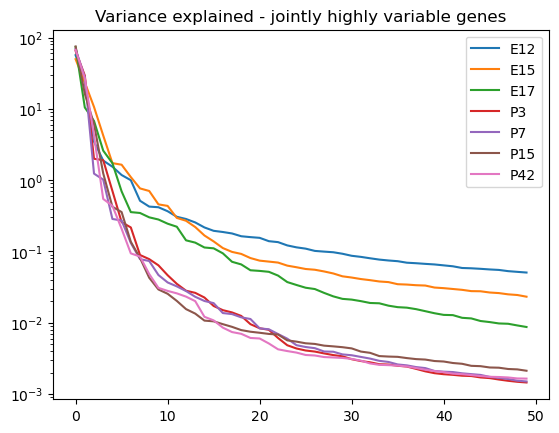

In [6]:
plt.plot(range(len(df_var)), df_var, label=df_var.columns)
plt.title('Variance explained - jointly highly variable genes')
plt.legend()
plt.yscale('log')
plt.show()

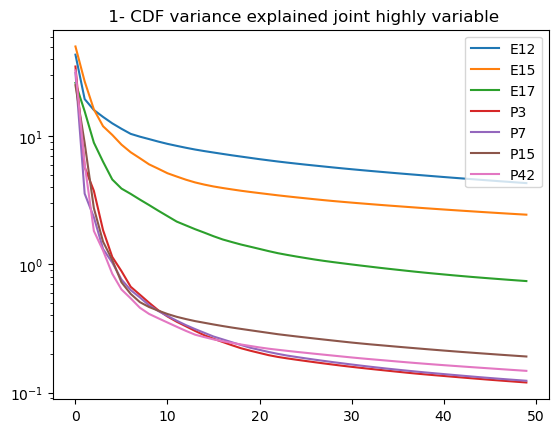

In [7]:
plt.plot(df_cumulative_var.index, 100-df_cumulative_var, label=df_var.columns)
plt.yscale('log')
plt.title(f' 1- CDF variance explained joint highly variable')
plt.legend()
plt.show()

In [64]:
thresh = 0.5

for cat in categories:
    print(f'Starting on {cat}, time is {time.strftime("%H:%M:%S", time.localtime())}')
    c_object = cnmf.cNMF(cnmf_dir, cat)

    df = cnmf.load_df_from_npz(c_object.paths['k_selection_stats_dt'] % c_object.convert_dt_to_str(thresh))
    pos = len(df) - 5
    for i in range(5):
        print(cnmf.find_knee_point(df.prediction_error[:pos + i], df.k_source[:pos + i]), end=", ")
    print()

Starting on E12, time is 22:21:30
5.0, 5.0, 5.0, 5.0, 6.0, 
Starting on E15, time is 22:21:30
6.0, 6.0, 6.0, 6.0, 7.0, 
Starting on E17, time is 22:21:30
5.0, 5.0, 5.0, 5.0, 5.0, 
Starting on P3, time is 22:21:30
5.0, 5.0, 5.0, 5.0, 5.0, 
Starting on P7, time is 22:21:30
5.0, 5.0, 5.0, 6.0, 6.0, 
Starting on P15, time is 22:21:30
4.0, 4.0, 4.0, 4.0, 4.0, 
Starting on P42, time is 22:21:30
4.0, 5.0, 5.0, 5.0, 5.0, 


In [65]:
%%time

selected_cnmf_params = {
    'E12': (6, 0.5),  # 
    'E15': (7, 0.5),  # 
    'E17': (5, 0.5),   # 
    'P3': (5, 0.5),    # 
    'P7': (6, 0.5),   # 
    'P15': (4, 0.5),  # 
    'P42': (5, 0.5)}   # 

split_adatas = {}

for cat, (k, threshold) in selected_cnmf_params.items():
    print(f'Working on epi {cat} with k={k} and threshold={threshold}')
    %time tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))

    tmp.var.joint_highly_variable = subset.var.joint_highly_variable
    
    c_object = cnmf.cNMF(cnmf_dir, cat)
    c_object.consensus(k, density_threshold=threshold, gpu=True, verbose=True,
                       nmf_refitting_iters=1000, show_clustering=False)

    usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)

    tmp.uns['cnmf_params'] = {'k_nmf': k, 'threshold': threshold}

    tmp.obsm['usages'] = usages.copy()

    usages_norm = usages / np.sum(usages, axis=1, keepdims=True)
    tmp.obsm['usages_norm'] = usages_norm

    # get per gene z-score of data after TPM normalization and log1p transformation 
    tpm_log1p_zscore = tmp.X.toarray()
    tpm_log1p_zscore /= 1e-6 * np.sum(tpm_log1p_zscore, axis=1, keepdims=True)
    tpm_log1p_zscore = np.log1p(tpm_log1p_zscore)
    tpm_log1p_zscore = sc.pp.scale(tpm_log1p_zscore)

    usage_coefs = _utils.fastols(usages_norm, tpm_log1p_zscore)

    tmp.varm['usage_coefs'] = pd.DataFrame(
        usage_coefs.T, index=tmp.var.index,
        columns=[f'{tmp.uns["sname"]}.p{prog}' for prog in range(usages.shape[1])])
    
    split_adatas[cat] = tmp

    tmp.write_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))

Working on epi E12 with k=6 and threshold=0.5
CPU times: user 173 ms, sys: 20.9 ms, total: 194 ms
Wall time: 1.5 s
Updating W based on consensus spectra
beta 1 loss = 1218351.75, # iterations was 180
Refitting W, H based on consensus
beta 1 loss = 1192307.0, # iterations was 400
Working on epi E15 with k=7 and threshold=0.5
CPU times: user 211 ms, sys: 141 ms, total: 352 ms
Wall time: 3.64 s
Updating W based on consensus spectra
beta 1 loss = 8488771.0, # iterations was 120
Refitting W, H based on consensus
beta 1 loss = 8406967.0, # iterations was 260
Working on epi E17 with k=5 and threshold=0.5
CPU times: user 187 ms, sys: 104 ms, total: 291 ms
Wall time: 2.91 s
Updating W based on consensus spectra
beta 1 loss = 5863806.5, # iterations was 80
Refitting W, H based on consensus
beta 1 loss = 5862091.5, # iterations was 70
Working on epi P3 with k=5 and threshold=0.5
CPU times: user 182 ms, sys: 39.6 ms, total: 222 ms
Wall time: 1.98 s
Updating W based on consensus spectra
beta 1 loss

### Examining results

In [2]:
%%time

split_adatas = {}
for cat in categories:
    split_adatas[cat] = sc.read_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))

NameError: name 'split_adatas_dir' is not defined

In [66]:
for cat in categories:
    print(cat)
    s = split_adatas[cat].obsm['usages_norm'].sum(axis=0)
    with np.printoptions(precision=2, suppress=False):
        print(s * 100 / s.sum())

E12
[ 7.22 13.15 17.32 19.   23.24 20.07]
E15
[30.48 26.58 11.85 10.14 15.92  1.47  3.56]
E17
[37.44 28.79 23.92  3.25  6.61]
P3
[43.93  3.53  4.62  5.93 41.99]
P7
[23.19  3.38 50.92 10.06  6.31  6.13]
P15
[33.38  3.22 51.85 11.55]
P42
[ 3.7  33.43 47.68  9.55  5.63]


In [67]:
decomposition_images = _utils.set_dir(split_adatas_dir.joinpath("images"))

for cat in categories:
    epidata = sc.read_h5ad(split_adatas_dir.joinpath(f"{cat}.h5ad"))
    
    # UMAP
    um = sc.pl.umap(epidata, color='celltype', s=10, return_fig=True, title=f'{cat} epithelial')
    plt.tight_layout()
    um.savefig(decomposition_images.joinpath(f"epi_{cat}_umap_celltype.png"), dpi=300)
    plt.close(um)

    # usages clustermap
    un_sns = _utils.plot_usages_norm_clustermaps(
        epidata, title=f'{cat}', show=False,sns_clustermap_params={
            'row_colors': epidata.obs['celltype'].map(epidata.uns['celltype_colors_dict'])})
    un_sns.savefig(decomposition_images.joinpath(f"{cat}_usages_norm.png"),
                   dpi=180, bbox_inches='tight')
    plt.close(un_sns.fig)

    # usages violin plot
    _utils.plot_usages_norm_violin(
        epidata, 'celltype', save_path=decomposition_images.joinpath(
            f'{cat}_norm_usage_per_lineage.png'))

/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plot

## 6. Running comparator on the data

In [68]:
%%time

column_of_interest = 'development_stage'
categories = ['E12', 'E15', 'E17', 'P3', 'P7', 'P15', 'P42']

results_dir = _utils.set_dir('results')
results_dir = _utils.set_dir(results_dir.joinpath('zepp'))

split_adatas_dir = _utils.set_dir(results_dir.joinpath(f'split_{column_of_interest}'))


split_adatas = {}
for cat in categories:
    split_adatas[cat] = sc.read_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))

CPU times: user 1.19 s, sys: 379 ms, total: 1.57 s
Wall time: 4.06 s


In [69]:
for cat in categories:
    tmp = split_adatas[cat]

    field_1 = 'celltype'

    tmp.obsm['row_colors'] = pd.concat([
        tmp.obs[field_1].map(tmp.uns[f'{field_1}_colors_dict']),
        ], axis=1)

In [71]:
%%time

pairs = [(categories[i], categories[i + 1]) for i in range(len(categories) - 1)]

for cat_a, cat_b in pairs:
    comparison_dir = _utils.set_dir(results_dir.joinpath(f"same_genes_{cat_a}_{cat_b}"))
    
    adata_a = split_adatas[cat_a]
    adata_b = split_adatas[cat_b]
    
    if os.path.exists(comparison_dir.joinpath('comparator.npz')):
        cmp = comparator.Comparator.load_from_file(comparison_dir.joinpath('comparator.npz'), adata_a, adata_b)
    else:
        cmp = comparator.Comparator(adata_a, adata_a.obsm['usages'], adata_b, comparison_dir,
                                    'torchnmf', device='cuda', max_nmf_iter=1000, verbosity=1,
                                   highly_variable_genes='joint_highly_variable')
        
        print('decomposing')
        cmp.extract_geps_on_jointly_hvgs()
        cmp.decompose_b(repeats = 5)
    
    cmp.examine_adata_a_decomposition_on_jointly_hvgs()
    
    cmp.print_errors()
    cmp.examine_adata_b_decompositions()
    cmp.plot_decomposition_comparisons()
    
    cmp.calculate_fingerprints()
    
    print('running GSEA')
    cmp.run_gsea(gprofiler_kwargs=dict(organism='mmusculus', sources=['GO:BP', 'WP', 'REAC', 'KEGG']))

    cmp.save_to_file(comparison_dir.joinpath('comparator.npz'))

Directory "results/zepp/same_genes_E12_E15" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/zepp/same_genes_E12_E15
decomposing
Extracting A GEPs on jointly highly variable genes
Decomposing B using A GEPs and no additional GEPs
beta 1 loss = 11643858.0, # iterations was 90
Decomposing B de-novo
Decomposing B de-novo, rank=6
beta 1 loss = 8305955.5, # iterations was 600
Decomposing B de-novo, rank=7
beta 1 loss = 8246415.5, # iterations was 830
Decomposing B de-novo, rank=8
beta 1 loss = 8204854.5, # iterations was 940
Decomposing B de-novo, rank=9
beta 1 loss = 8159935.0, # iterations was 900
Decomposing B using A GEPs and up to 3 additional GEPs
Working on added rank = 1
repeat 0, after 97 iterations reached error =  8674225.7
repeat 1, after 98 iterations reached error =  8674225.0
repeat 3, after 98 iterations reached error =  8674218.9
repeat 4, after 97 iterations reached error =  8674199.5
Working on added rank = 2
repeat 0, after 172 iter